In [1]:
using Pkg
Pkg.activate("/media/mat/HDD/QROMP/")

 Activating environment at `/media/mat/HDD/QROMP/Project.toml`


In [2]:
using Revise
using LinearAlgebra
using Statistics
using BenchmarkTools
using QROMP
using Permutations
using Test
using Plots
using Convex
using ElasticArrays

┌ Info: Precompiling QROMP [2ae2181e-4684-4b2c-a413-203f2dd831ec]
└ @ Base loading.jl:1278


In [5]:
A = ElasticMatrix(zeros(100,0))
@time for i in 1:50
    append!(A, randn(100))
end

  0.000055 seconds (57 allocations: 143.328 KiB)


In [7]:
B = zeros(100,0)

@time for i in 1:100
    B = hcat(B, randn(100))
#     append!(B, randn(2))
end

  0.000453 seconds (280 allocations: 3.948 MiB)


In [8]:
ψ = randn(500, 100)
u = randn(500)
m, n = size(ψ)
ctrue = ψ\u

100-element Array{Float64,1}:
 -0.05066234986597202
 -0.05475662379432709
 -0.06770982721197354
  0.004699289764980181
 -0.021467225943891593
 -0.062304359070385174
  0.08515723002984348
 -0.046320529719885234
  0.042949970418955555
  0.005520319802717825
 -0.007523930119647772
  0.01890189808914533
 -0.05698272077180091
  ⋮
  0.02598689684036429
 -0.0714054899302818
 -0.043154772869727555
  0.020048768337963086
  0.01861853907205052
 -0.018789356361489564
  0.015849386440885245
  0.019917833634316495
  0.026891745183185753
  0.012347915094266885
 -0.04219581217562957
  0.05796202530539707

In [27]:
ψ = randn(5000, 100)
ctrue = randn(100)
u = ψ*ctrue
m, n = size(ψ)

# Force a greedy approach over the entire set of indices
# With LS
@time idxls, cls, ϵls = lsomp(ψ, u; invert = true, verbose = true, ϵrel = eps())

# With QR
@time idxqr, cqr, ϵqr = qromp(ψ, u; invert = true, verbose = true, ϵrel = eps())

# With pivoted QR
@time idxpivot, cpivot, ϵpivot = pivotedqr(ψ, u; invert = true, verbose = true, ϵrel = eps())


# @test norm(idxls - idxqr)<1e-14
@test norm(ctrue[idxqr]-cqr)<5e-14
@test norm(ctrue[idxls]-cls)<5e-14
@test norm(ctrue[idxpivot]-cpivot)<5e-14
# @test norm(ϵls-ϵqr)<1e-14

  0.383973 seconds (34.52 k allocations: 224.623 MiB, 1.39% gc time)
  0.131733 seconds (1.77 k allocations: 19.392 MiB)
  0.354622 seconds (34.52 k allocations: 228.425 MiB, 1.03% gc time)


Test Passed

In [20]:
idxpivot, cpivot, ϵpivot = greedysolver("pivotedqr", ψ, u; invert = true, verbose = true, ϵrel = eps())

([51, 8, 63, 71, 55, 82, 17, 59, 60, 99  …  61, 73, 32, 47, 12, 100, 35, 9, 46, 14], [-0.6379865834148943, 0.7413483707148484, -1.3617374455850835, 0.28919018929920265, -1.4286433239978682, -0.7430263334232934, 1.2942463192052671, 0.037935210654754525, -1.3528110462633482, -0.7394875183293773  …  0.18089494272148435, -1.1415090322739956, -1.1131974541891503, 2.409255358970116, 1.1866343533736883, -1.0096758211727677, -0.3469876374455802, -1.245529226896579, -0.19086996502527598, -0.2691711204732382], [653.1547798894654, 651.6470515330157, 649.709320365067, 641.9084529197695, 641.3301480824231, 633.5287892789645, 629.6035989184647, 620.6741580389862, 620.6324588722454, 614.8476042996134  …  244.59052522295485, 230.55215326223123, 218.1461531528082, 141.06144479598092, 115.55295093258755, 91.63392059893694, 88.5063169176576, 22.46562889811696, 18.301913049596173, 3.8609654046557226e-13])

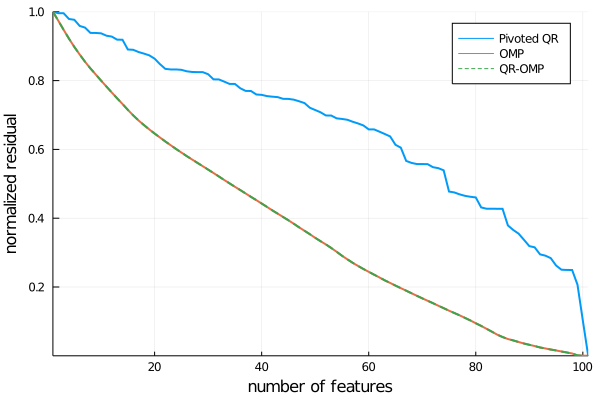

In [28]:
plt = plot(ϵpivot./norm(u), linewidth = 2, label = "Pivoted QR", 
    xlim = (-Inf, Inf), xlabel = "number of features",
    ylim = (-Inf, Inf), ylabel = "normalized residual")
plot!(ϵls./norm(u), linewidth = 2, label = "OMP")
plot!(ϵqr./norm(u), linewidth = 2, label = "QR-OMP", linestyle = :dash)
# savefig("greedy_test.pdf")
plt